**Preliminaries.** For nice interactive plots, add the Interact.jl and the PyPlot.jl packages. If you have IPython 3, you will need to checkout the git master branch of the Interact package.

In [19]:
#Pkg.checkout("Interact") #(optional) for interactive plots
#Pkg.add("PyPlot") # for standard plots

In [1]:
using PyPlot #slightly longer to load
using Interact
using Autoreload #delete

INFO: Loading help data...


In [10]:
using HDF5, JLD
arequire("Grids.jl") #replace by require
arequire("DynamicOT.jl") 
arequire("PlotGrids.jl")

In [11]:
using Grids
using DynamicOT
using PlotGrids

**Notice.** An approximate minizer of
$$
\int_0^1 \left[ \int_{\Omega} \frac1p \frac{|\omega|^p}{\rho^{p-1}}dx + 
\delta^p \int_{\Omega} \frac1q \frac{|\zeta|^q}{\rho^{q-1}}dx\right] dt
$$
subject to 
$$
\partial_t \rho + \nabla \cdot \omega = \zeta, \quad \rho(0,\cdot)=\rho_0 \quad  \text{and} \quad \rho(1,\cdot)=\rho_1 ,
$$
is computed by calling

    solveGeodesic(ρ_0, ρ_1, T, (p,q), δ ,niter)
with the following arguments:
* `ρ_0, ρ_1` : arrays of float of same dimensions containing the densities;
* `T` : is the number of time discretization samples;
* `(p,q)` : couple of integers : by convention, put `p=0` to forbid transport and `q=0` to forbid source. In particular:
  * `(1,0)` : $W_1$
  * `(2,0)` : $W_2$
  * `(1,1)` : $W_1-TV$ Hanin distance (subcase of Piccoli-Rossi distances);
  * `(1,2)` : $W_2-TV$ Optimal Partial transport (subcase of Piccoli-Rossi distances);
  * `(2,1)` : $W_1-FR$ interpolation between $W_1$ and Fisher-Rao;
  * `(2,2)` : **The Wasserstein-Fisher-Rao metric $W\!F$**;
* `δ` : interpolation weight, also determines the maximum distance mass can travel (when $q\neq 0)$. *Caution*: values of `\delta` above $10$ lead to ill-conditioned problems.
* `niter` : number of iterations.    

#The travelling concentrated measures

**Concentrated Gaussians.** Notice how the behavior changes when $\delta$ varies near $\frac{1}{\pi}$. Consider a Gaussian of variance $\sigma$ and mass $1$ travelling from $x_0$ to $x_1$.

In [23]:
σ = 0.03;
T = 11; K = 256; x = linspace(0,1,K); # discretization of the time-space domain
gauss = (x,x_0,σ,mass) -> mass*(exp(-(x-x_0).^2/σ^2)*K/sum(exp(-(x-x_0).^2/σ^2))); # gaussian bump
ρ_0 = gauss(x,0.2,σ,1) + gauss(x,0.9,σ,2); #initial density
ρ_1 = gauss(x,0.3,σ,2) + gauss(x,0.65,σ,1); #final density
;

In [24]:
(U,minF,Flist,Clist,Ilist) = solveGeodesic(ρ_0, ρ_1, T, order=(2.,1.), δ=.5/π ,niter=2500);

Computing a geodesic for optimal transport with source...
Progress: 100.0%
Done.


## Interactive plot
Move the cursor to observe the interpolation
(if you don't want to install the `interactive` package, skip this block)

Slider{Int64}([Input{Int64}] 6,"t",6,1:11)

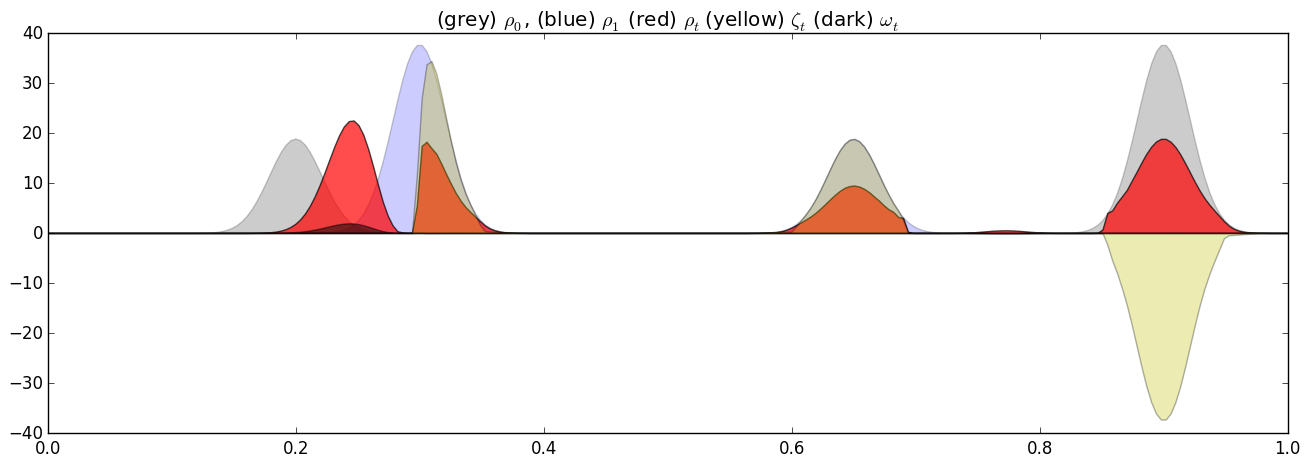

In [15]:
f = figure(figsize=[16,5])
V=interp(U) # put all variables on the centered grid
@manipulate for t=1:T ; withfig(f) do
        fill(x,ρ_0,"k",alpha=0.2);fill(x,ρ_1,"b",alpha=0.2)
        fill(x,V.ρ[t,:]'   ,"r",alpha=0.7)
        fill(x,V.ω[1][t,:]',"k",alpha=0.5)
        fill(x,U.ζ[t,:]'   ,"y",alpha=0.3)
        title(L"(grey) $\rho_0$, (blue) $\rho_1$ (red) $\rho_{t}$ (yellow) $\zeta_t$ (dark) $\omega_t$")
    end
end

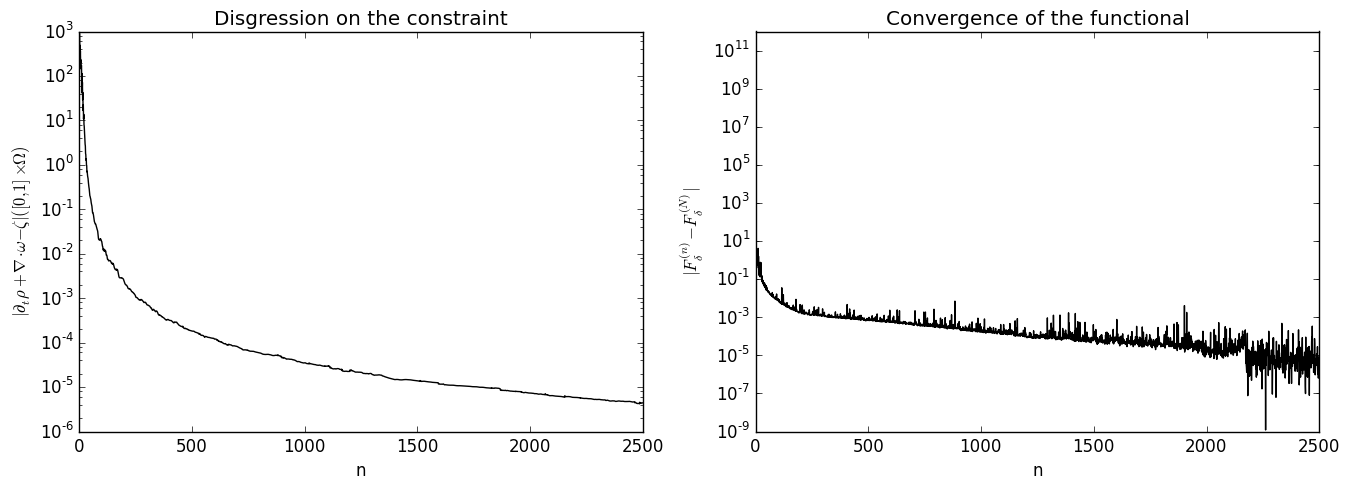

In [16]:
f = figure(figsize=[16,5])
subplot(1,2,1)
ylabel(L"$|\partial_t \rho + \nabla \cdot \omega - \zeta|([0,1]\times \Omega)$")
xlabel("n")
title("Disgression on the constraint")
semilogy(Clist[1:end],"k")
subplot(1,2,2)
ylabel(L"$|F_{\delta}^{(n)}-F_{\delta}^{(N)}|$")
xlabel("n")
title("Convergence of the functional")
semilogy(abs(Flist[1:end]-mean(Flist[end-10:end])),"k");

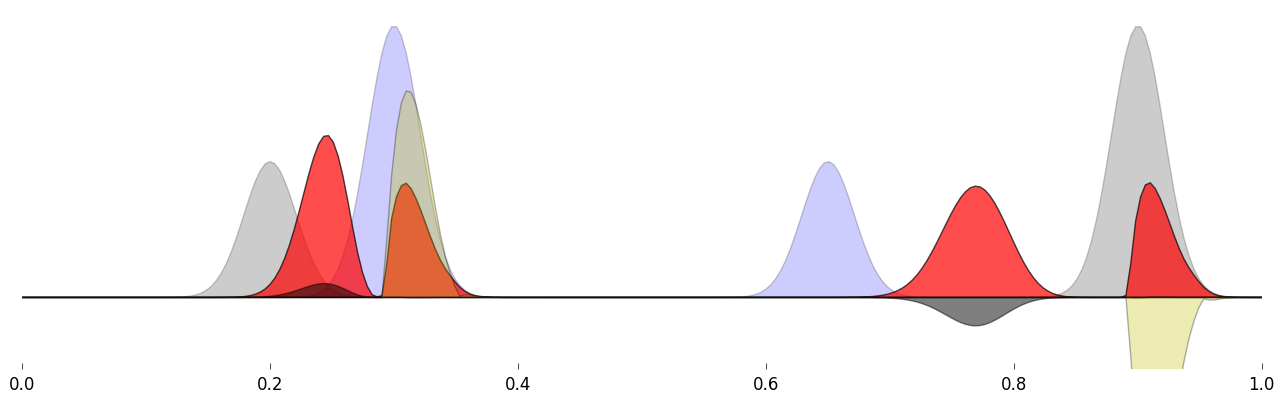

In [26]:
fig, ax = subplots(figsize=[16,4.5],1,1)
V=interp(U) # put all variables on the centered grid
t=6 # choose which "picture" display
ax1 = fill(x,ρ_0,"k",alpha=0.2); fill(x,ρ_1,"b",alpha=0.2)
fill(x,V.ρ[t,:]',"r",alpha=0.7)
fill(x,V.ω[1][t,:]',"k",alpha=0.5)
fill(x,[0,U.ζ[t,2:end-1]',0],"y",alpha=0.3)
axis([0., 1., -10, 40])
yax = ax[:axes][:get_yaxis]();
yax[:set_visible](false)
ax[:set_frame_on](false)
xax= ax[:get_xaxis]()
xax[:tick_bottom]()

# Synthetic 2D case

sum(ρ_0) => 1.0
sum(ρ_1) => 0.6295336787564769


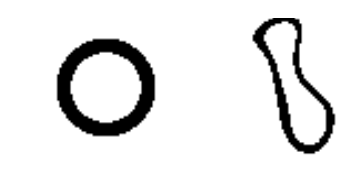

In [62]:
# create a ring
N   = 64; σ = .4
f   = (x,y) -> float64(1/4<x^2+y^2<1/2)
ρ_0 = float64([f(x,y) for x in linspace(-1.,1.,N), y in linspace(-1.,1.,N)])
s   = sum(ρ_0)
ρ_0 /= s

# smooth deformation field
ker  = float64([exp(-x^2/σ^2)/sqrt(2*π*σ^2)/10 for x in linspace(-1.,1.,N)])
indN = floor(N/2)
v1   = conv2(ker,ker,randn(N,N));   v1 = v1[indN:indN+N-1,indN:indN+N-1]/1
v1   = conv2(ker,ker,v1);           v1 = v1[indN:indN+N-1,indN:indN+N-1]/1
v2   = conv2(ker,ker,randn(N,N));   v2 = v2[indN:indN+N-1,indN:indN+N-1]/1
v2   = conv2(ker,ker,v2);           v2 = v2[indN:indN+N-1,indN:indN+N-1]/1
push = (x,y) -> (x+1.*(v1[floor(x*N/2+N/2+1),floor(y*N/2+N/2+1)]),y+1.*(v2[floor(x*N/2+N/2+1),floor(y*N/2+N/2+1)]))
ρ_1  = float64([f(push(x,y)...) for x in linspace(-.99,.99,N), y in linspace(-.99,.99,N)])/s
# plot
figure(figsize=[4,10])
subplot(121)
imshow(ρ_0, cmap="Greys"); axis("off")
subplot(122)
imshow(ρ_1, cmap="Greys"); axis("off")
@show sum(ρ_0); @show sum(ρ_1);

In [ ]:
T=12;
(U,minF,Flist,Clist,Ilist) = solveGeodesic(ρ_0, ρ_1, T, order=(2.,0.), δ=.4/π ,niter=1000);
;

Computing geodesic for standard optimal transport...
Progress: 4.0%

In [60]:
figure(figsize = [4,10])
plot2d(U,10,3)

256-element Array{Float64,1}:
 9.41947e-19
 5.2911e-18 
 2.87226e-17
 1.50681e-16
 7.63927e-16
 3.74286e-15
 1.7722e-14 
 8.10924e-14
 3.58596e-13
 1.53246e-12
 6.32894e-12
 2.52598e-11
 9.7429e-11 
 ⋮          
 1.03937    
 0.622505   
 0.360306   
 0.201538   
 0.108944   
 0.0569122  
 0.028732   
 0.0140179  
 0.00660939 
 0.00301159 
 0.00132614 
 0.000564338

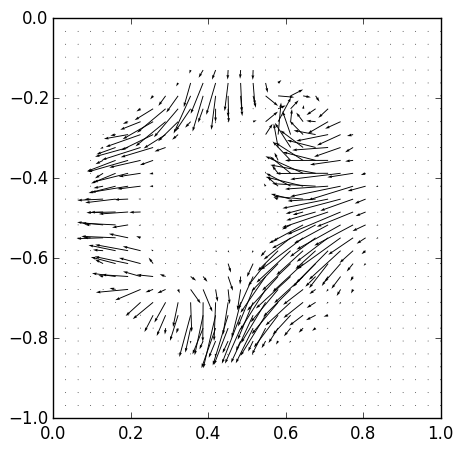

In [80]:
t = 6; figure(figsize=[5,5])
X = linspace(0,1,V.cdim[2]);
Y = linspace(0,1,V.cdim[2]);
quiver(X,-Y,reshape(V.ω[2][t,:],V.cdim[2:end]...), reshape(V.ω[1][t,:],V.cdim[2:end]...));

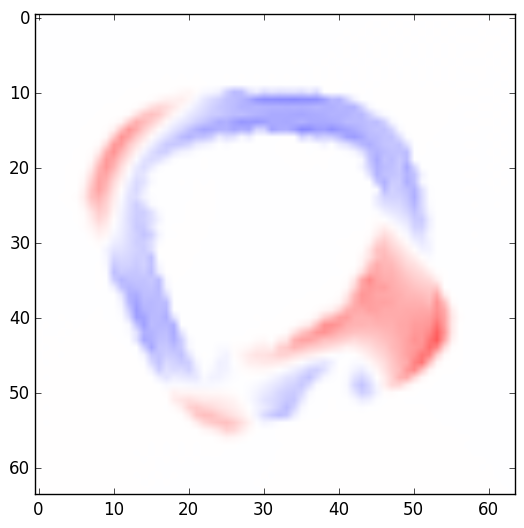

PyObject <matplotlib.image.AxesImage object at 0x117b92e80>

In [24]:
X=load("exp/ring_p2q2.jld")
U=X["U"];
V=interp(U);
t=6;
v1 = zeros(U.cdim[2:end]...);
v2 = zeros(U.cdim[2:end]...);
ζ = reshape(U.ζ[t,:],U.cdim[2:end]...)
ρ = reshape(U.ρ[t,:],U.cdim[2:end]...);
#[ρ.>1e-5]=ζ[ρ.>1e-5]./ρ[ρ.>1e-5];

imshow(ζ,cmap="bwr",vmin=-.001, vmax=.001)
#imsave("images/circle_p2q2_z$(t)",ζ,cmap="bwr",vmin=-.001, vmax=.001)

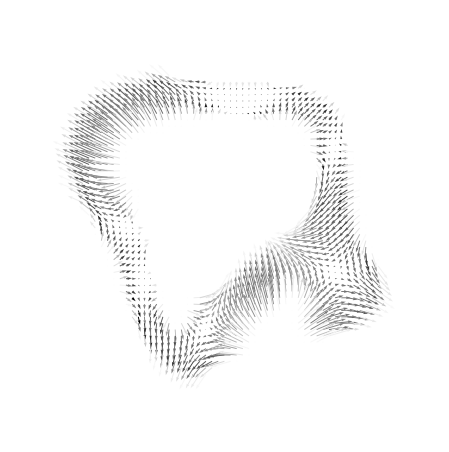

In [25]:
plotVelocity(U);

#savefig("images/circle_p2q2_v.eps")

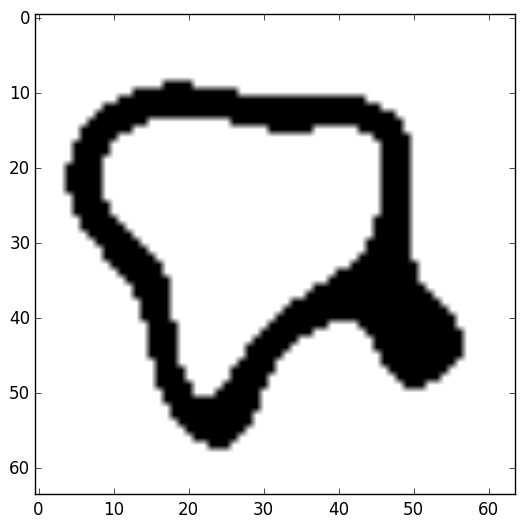

In [106]:
X=load("exp/ring_p2q1.jld")
U=X["U"];

for t=1:U.cdim[1]+1
ρ = reshape(U.ρ[t,:],U.cdim[2:end]...);
imshow(ρ,cmap="Greys",vmin=0, vmax=.001)
#imsave("images/circle_p2q1_r$(t)",ρ,cmap="Greys",vmin=0, vmax=.001)
end